### 📘 Project Overview: Forecasting Apple (AAPL) Stock Prices with LSTM

This project focuses on developing a deep learning model to forecast Apple’s stock price using historical time-series data. Long Short-Term Memory (LSTM) networks are well suited for financial forecasting because they capture temporal dependencies and long-range patterns.

The key objectives of this project are:

- To explore and preprocess Apple stock data
- To transform the time series into a supervised learning format
- To design and train an LSTM-based neural network
- To evaluate model performance using RMSE and visual diagnostics
- To compare predicted versus actual price behaviors

This notebook walks through the complete workflow — from exploratory analysis to model training and final prediction — and demonstrates how deep learning can be applied to financial forecasting tasks in a clear and reproducible manner.

In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [2]:
# So runs are consist
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
# Importing the training set
train_df = pd.read_csv('dataset/AAPL.xls')

## 1. EDA

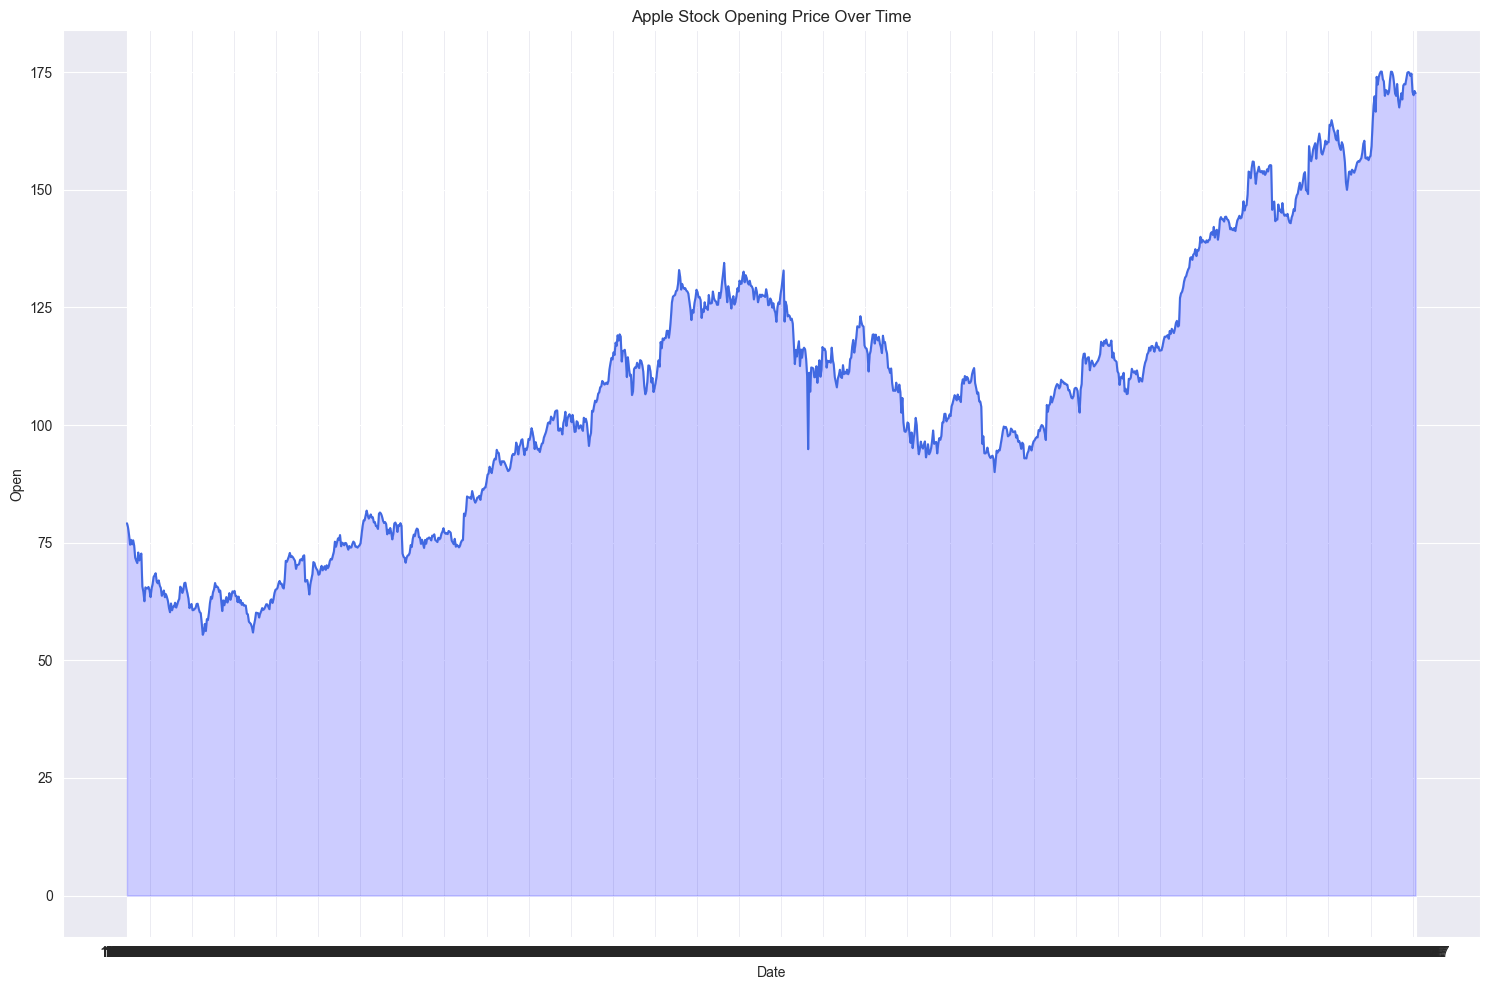

In [4]:
# Visual plot of apple stock oppening over time
sns.set_style('darkgrid')
plt.figure(figsize=(15, 10))
plt.plot(train_df['Date'], train_df['Open'], color='royalblue')
plt.fill_between(train_df['Date'], train_df['Open'], color='blue', alpha=0.2)
plt.title('Apple Stock Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Open')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [5]:
train_df.head()

,Date,Open
0,1/2/2013,79.117142
1,1/3/2013,78.268570
2,1/4/2013,76.709999
3,1/7/2013,74.571426
4,1/8/2013,75.601425


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Open    1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [7]:
train_df.describe()

,Open
count,1259.000000
mean,106.953082
std,29.630323
min,55.424286
25%,79.675716
50%,107.879997
75%,125.994999
max,175.110001


In [8]:
train_df.tail()

,Date,Open
1254,12/22/2017,174.679993
1255,12/26/2017,170.800003
1256,12/27/2017,170.100006
1257,12/28/2017,171.000000
1258,12/29/2017,170.520004


In [9]:
train_df.dtypes

Date     object
Open    float64
dtype: object

In [10]:
train = train_df.iloc[:, 1:2].values

In [11]:
train

array([[ 79.117142],
       [ 78.26857 ],
       [ 76.709999],
       ...,
       [170.100006],
       [171.      ],
       [170.520004]], shape=(1259, 1))

In [12]:
# Feature scaling
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)

In [13]:
# Create a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Reshape X_train
X_train = np.reshape(X_train, shape=(X_train.shape[0], X_train.shape[1], 1))

## 3. Build The LSTM

In [15]:
# Initialising the RNN
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(300, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

In [16]:
# Compile the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Display the architecture of the RNN model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 300)             │         362,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,701 (2.61 MB)

 Trainable params: 683,701 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train The LSTM

In [18]:
# Fitting the RNN to the training set
history = model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.0266
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0040
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0034
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0034
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0030
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 0.0026
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0025
Epoch 8/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0030
Epoch 9/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 0.0029
Epoch 10/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 0.0025
Epoch 11/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0031
Epoch 12/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0026
Epoch 13/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0020
Epoch 14/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0024
Epoch 15/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 

## 5. Make The Prediction

In [19]:
test_df = pd.read_csv('dataset/AAPL - Jan2018.xls')

In [20]:
test_df.head()

,Date,Open
0,1/2/2018,170.160004
1,1/3/2018,172.529999
2,1/4/2018,172.539993
3,1/5/2018,173.440002
4,1/8/2018,174.350006


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


In [22]:
test_df.describe()

,Open
count,20.000000
mean,174.378999
std,3.369526
min,165.529999
25%,172.537495
50%,174.529999
75%,177.262501
max,179.369995


In [23]:
test_df.tail()

,Date,Open
15,1/24/2018,177.250000
16,1/25/2018,174.509995
17,1/26/2018,172.000000
18,1/29/2018,170.160004
19,1/30/2018,165.529999


In [24]:
test_df.dtypes

Date     object
Open    float64
dtype: object

In [25]:
# Actual stock price
actual_stock_price = test_df.iloc[:, 1:2].values
df = pd.concat((train_df, test_df), axis=0)
inputs = df.iloc[len(df)-len(test_df)-60: , 1:2].values
# Feature scaling
inputs = sc.transform(inputs)

In [26]:
# Create a data structure with 60 timesteps
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i])

X_test = np.array(X_test)

In [27]:
X_test

array([[[0.82512526],
        [0.83172595],
        [0.83874431],
        ...,
        [0.95814041],
        [0.96566005],
        [0.96164958]],

       [[0.83172595],
        [0.83874431],
        [0.84083311],
        ...,
        [0.96566005],
        [0.96164958],
        [0.95864171]],

       [[0.83874431],
        [0.84083311],
        [0.84008117],
        ...,
        [0.96164958],
        [0.95864171],
        [0.97844353]],

       ...,

       [[0.90625446],
        [0.93975883],
        [0.95621862],
        ...,
        [1.01829794],
        [1.01788015],
        [0.99498682]],

       [[0.93975883],
        [0.95621862],
        [0.92889715],
        ...,
        [1.01788015],
        [0.99498682],
        [0.97401527]],

       [[0.95621862],
        [0.92889715],
        [0.9907257 ],
        ...,
        [0.99498682],
        [0.97401527],
        [0.95864171]]], shape=(20, 60, 1))

In [28]:
# Making the predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## 6. Visualize The Results

In [29]:
rmse = math.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
rmse

4.663595117722539

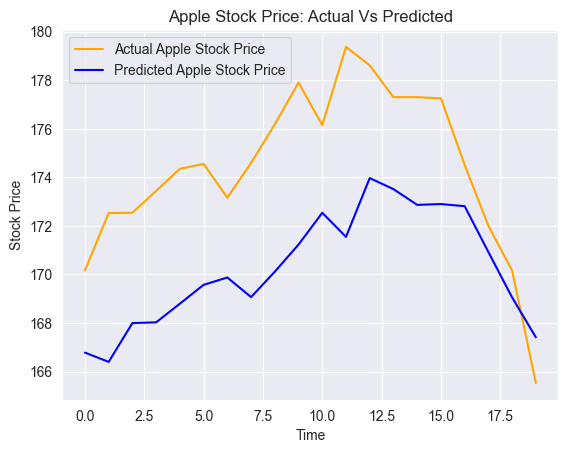

In [30]:
# Plot the actual apple stock price vs predicted apple stock price
plt.plot(actual_stock_price, label='Actual Apple Stock Price', color='orange')
plt.plot(predicted_stock_price, label='Predicted Apple Stock Price', color='blue')
plt.title('Apple Stock Price: Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

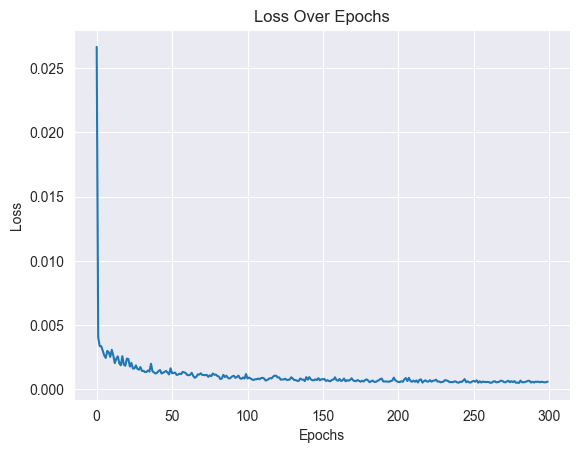

In [31]:
# Plot the loss over epochs
plt.plot(history.history['loss'])
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Conclusion

In this project, we successfully developed an LSTM-based deep learning model to forecast Apple’s stock price using historical opening prices. After preparing and scaling the data, constructing a supervised learning dataset, and training the model, we generated predictions and evaluated accuracy using RMSE and visual analysis.

The model captured the general trend of the stock movement; however, several opportunities exist to enhance performance:

- Incorporating additional features such as high, low, close, and trading volume
- Using longer training windows or experimenting with advanced architectures (GRU, bidirectional LSTM, transformers)
- Introducing regularization and early stopping to avoid overfitting
- Performing more comprehensive EDA to better understand underlying data patterns

Despite limitations, the project demonstrates the effectiveness of recurrent neural networks for time-series forecasting and provides a solid foundation for more sophisticated financial modeling.